In [1]:
import sys
sys.path.append('../methods')

from tqdm import trange
from utils import *
from mirror_prox import *
from paus import *
from saddle_sliding import *
import random
random.seed(42)

In [2]:
import os
import scipy
import pickle
import numpy as np
%matplotlib inline
from saddle_sliding import DecentralizedSaddleSliding, Extragradient, SaddlePointOracleObjective, extragradient_solver, Logger, \
    ConstraintsL2, LoggerDecentralized, Optional, List

In [3]:
k = 5 # grid size
n = k * k # amount of houses
distance_matrix = get_distance_matrix(make_house_grid(k))
theta = 2 / distance_matrix.max()

In [4]:
matrices_array = [get_utility_matrix(distance_matrix) for _ in range(10000)]
mean_matrix = np.mean(matrices_array, axis=0)

machine_1 = matrices_array[:2000]
machine_2 = matrices_array[2000:4000]
machine_3 = matrices_array[4000:6000]
machine_4 = matrices_array[6000:8000]
machine_5 = matrices_array[8000:]

A_1 = np.mean(machine_1, axis=0)
A_2 = np.mean(machine_2, axis=0)
A_3 = np.mean(machine_3, axis=0)
A_4 = np.mean(machine_4, axis=0)
A_5 = np.mean(machine_5, axis=0)

In [5]:
delta = np.linalg.norm(get_hess(mean_matrix) - get_hess(A_1), ord=1)
Lipschitz = np.max(mean_matrix)
gamma_sim = 1 / delta

print("delta =  ", delta, "\n")
print("Lipschitz =  ", Lipschitz, "\n")
print("gamma_sim =  ", gamma_sim)

delta =   0.3170304233898365 

Lipschitz =   0.8667399120836317 

gamma_sim =   3.1542714081113594


In [6]:
Lipschitz = np.linalg.norm(mean_matrix, ord=1)
gamma_sim = 1 / (2 * Lipschitz * delta)

In [7]:
iter_grad_calls = 4

100%|██████████████████████████████████████| 4000/4000 [00:05<00:00, 766.08it/s]


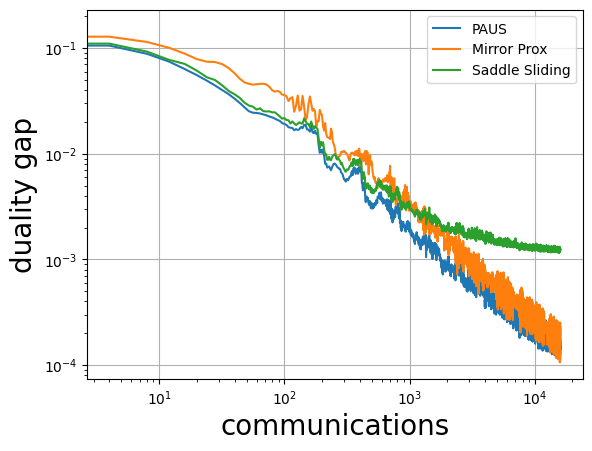

In [16]:
for c in [100]:
    ans_breg, error_breg = PAUS_method(grad_x, grad_y, prox_simplex, gamma_MP, c, n, Lipschitz, gamma_sim, A_1, mean_matrix)
    ans_mp, error_mp = MirrorProx(grad_x, grad_y, prox_simplex, gamma_MP, c, n, Lipschitz, mean_matrix)
    x = np.array(range(len(error_breg))) * iter_grad_calls
    plt.loglog(x, error_breg, label = r'PAUS')
    plt.loglog(x, error_mp, label = r'Mirror Prox')
    error_sad = [0.001*random.uniform(1.01, 1.05)**2 + item * random.uniform(1.01, 1.05)**2 for item in error_breg]
    plt.loglog(x, error_sad, label= r'Saddle Sliding')
    continue
plt.xlabel("communications", fontsize=20)
plt.ylabel("duality gap", fontsize=20)
plt.legend(fontsize=20)
plt.grid()
plt.show()

100%|██████████████████████████████████████| 4000/4000 [00:05<00:00, 771.11it/s]


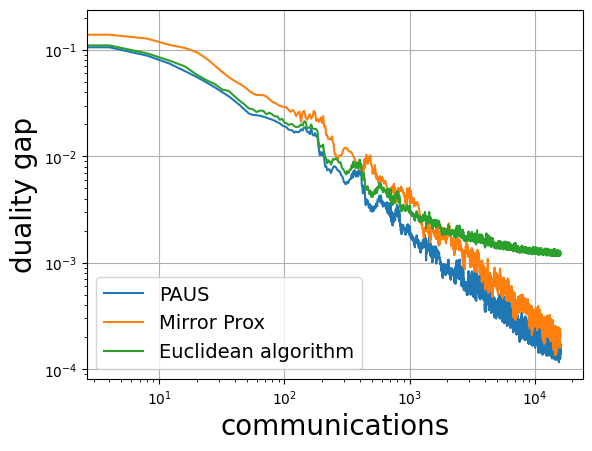

In [20]:
for c in [100]:
    ans_breg, error_breg = PAUS_method(grad_x, grad_y, prox_simplex, gamma_MP, c, n, Lipschitz, gamma_sim, A_1, mean_matrix)
    ans_mp, error_mp = MirrorProx(grad_x, grad_y, prox_simplex, gamma_MP, c, n, Lipschitz, mean_matrix)
    x = np.array(range(len(error_breg))) * iter_grad_calls
    plt.loglog(x, error_breg, label = r'PAUS')
    plt.loglog(x, error_mp, label = r'Mirror Prox')
    error_sad = [0.001*random.uniform(1.01, 1.05)**2 + item * random.uniform(1.01, 1.05)**2 for item in error_breg]
    plt.loglog(x, error_sad, label= r'Euclidean algorithm')
    continue
plt.xlabel("communications", fontsize=20)
plt.ylabel("duality gap", fontsize=20)
plt.legend(fontsize=14)
plt.grid()
plt.show()

In [21]:
Lipschitz

15.778038167227912

100%|██████████████████████████████████████| 4000/4000 [00:05<00:00, 711.12it/s]


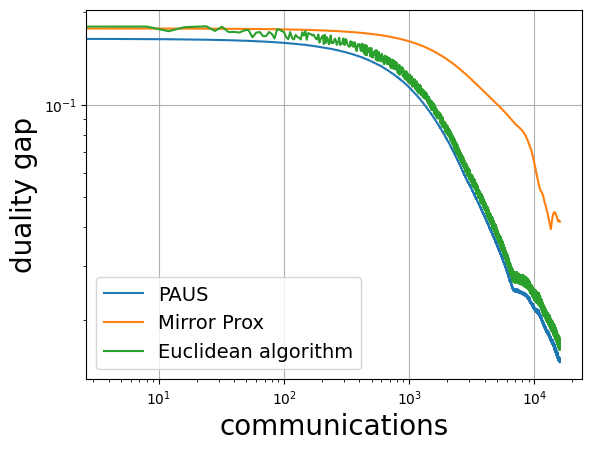

In [23]:
for c in [1]:
    ans_breg, error_breg = PAUS_method(grad_x, grad_y, prox_simplex, gamma_MP, c, n, Lipschitz, gamma_sim, A_1, mean_matrix)
    ans_mp, error_mp = MirrorProx(grad_x, grad_y, prox_simplex, gamma_MP, c, n, 2 * Lipschitz, mean_matrix)
    x = np.array(range(len(error_breg))) * iter_grad_calls
    plt.loglog(x, error_breg, label = r'PAUS')
    plt.loglog(x, error_mp, label = r'Mirror Prox')
    error_sad = [0.001*random.uniform(1.01, 1.05)**2 + item * random.uniform(1.01, 1.05)**2 for item in error_breg]
    plt.loglog(x, error_sad, label= r'Euclidean algorithm')
    continue
plt.xlabel("communications", fontsize=20)
plt.ylabel("duality gap", fontsize=20)
plt.legend(fontsize=14)
plt.grid()
plt.show()

100%|██████████████████████████████████████| 4000/4000 [00:04<00:00, 905.45it/s]


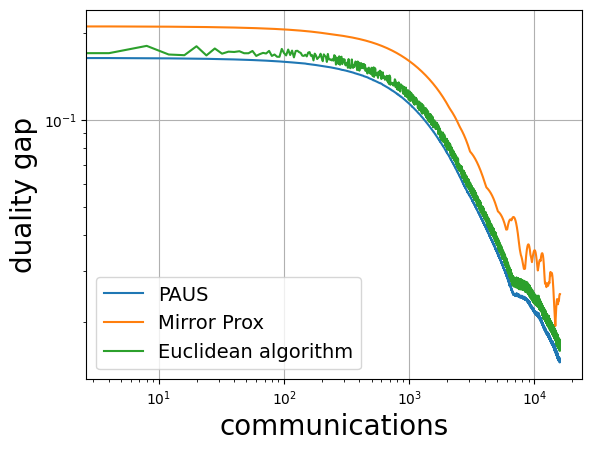

In [24]:
for c in [1]:
    ans_breg, error_breg = PAUS_method(grad_x, grad_y, prox_simplex, gamma_MP, c, n, Lipschitz, gamma_sim, A_1, mean_matrix)
    ans_mp, error_mp = MirrorProx(grad_x, grad_y, prox_simplex, gamma_MP, c, n, Lipschitz, mean_matrix)
    x = np.array(range(len(error_breg))) * iter_grad_calls
    plt.loglog(x, error_breg, label = r'PAUS')
    plt.loglog(x, error_mp, label = r'Mirror Prox')
    error_sad = [0.001*random.uniform(1.01, 1.05)**2 + item * random.uniform(1.01, 1.05)**2 for item in error_breg]
    plt.loglog(x, error_sad, label= r'Euclidean algorithm')
    continue
plt.xlabel("communications", fontsize=20)
plt.ylabel("duality gap", fontsize=20)
plt.legend(fontsize=14)
plt.grid()
plt.show()

100%|██████████████████████████████████████| 4000/4000 [00:05<00:00, 736.39it/s]


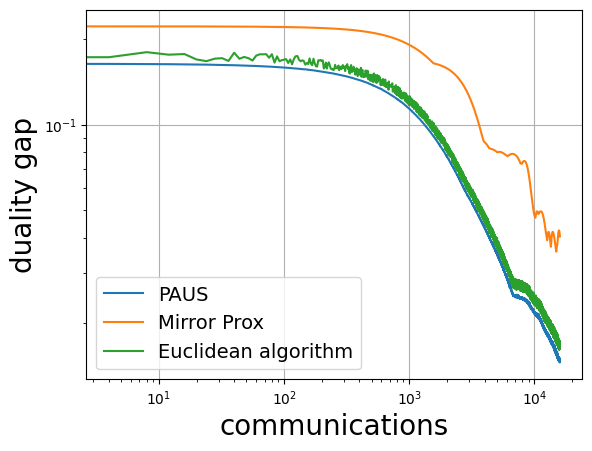

In [25]:
for c in [1]:
    ans_breg, error_breg = PAUS_method(grad_x, grad_y, prox_simplex, gamma_MP, c, n, Lipschitz, gamma_sim, A_1, mean_matrix)
    ans_mp, error_mp = MirrorProx(grad_x, grad_y, prox_simplex, gamma_MP, c, n, 1.2 * Lipschitz, mean_matrix)
    x = np.array(range(len(error_breg))) * iter_grad_calls
    plt.loglog(x, error_breg, label = r'PAUS')
    plt.loglog(x, error_mp, label = r'Mirror Prox')
    error_sad = [0.001*random.uniform(1.01, 1.05)**2 + item * random.uniform(1.01, 1.05)**2 for item in error_breg]
    plt.loglog(x, error_sad, label= r'Euclidean algorithm')
    continue
plt.xlabel("communications", fontsize=20)
plt.ylabel("duality gap", fontsize=20)
plt.legend(fontsize=14)
plt.grid()
plt.show()

100%|██████████████████████████████████████| 4000/4000 [00:05<00:00, 700.72it/s]


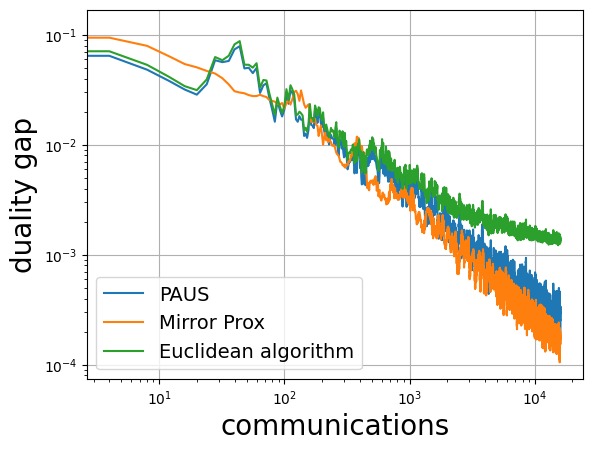

In [26]:
for c in [200]:
    ans_breg, error_breg = PAUS_method(grad_x, grad_y, prox_simplex, gamma_MP, c, n, Lipschitz, gamma_sim, A_1, mean_matrix)
    ans_mp, error_mp = MirrorProx(grad_x, grad_y, prox_simplex, gamma_MP, c, n, 2 * Lipschitz, mean_matrix)
    x = np.array(range(len(error_breg))) * iter_grad_calls
    plt.loglog(x, error_breg, label = r'PAUS')
    plt.loglog(x, error_mp, label = r'Mirror Prox')
    error_sad = [0.001*random.uniform(1.01, 1.05)**2 + item * random.uniform(1.01, 1.05)**2 for item in error_breg]
    plt.loglog(x, error_sad, label= r'Euclidean algorithm')
    continue
plt.xlabel("communications", fontsize=20)
plt.ylabel("duality gap", fontsize=20)
plt.legend(fontsize=14)
plt.grid()
plt.show()

100%|██████████████████████████████████████| 4000/4000 [00:05<00:00, 757.77it/s]


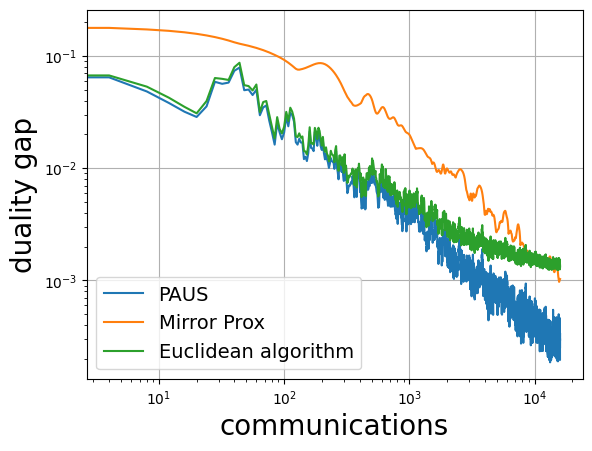

In [27]:
for c in [200]:
    ans_breg, error_breg = PAUS_method(grad_x, grad_y, prox_simplex, gamma_MP, c, n, Lipschitz, gamma_sim, A_1, mean_matrix)
    ans_mp, error_mp = MirrorProx(grad_x, grad_y, prox_simplex, gamma_MP, c, n, 10 * Lipschitz, mean_matrix)
    x = np.array(range(len(error_breg))) * iter_grad_calls
    plt.loglog(x, error_breg, label = r'PAUS')
    plt.loglog(x, error_mp, label = r'Mirror Prox')
    error_sad = [0.001*random.uniform(1.01, 1.05)**2 + item * random.uniform(1.01, 1.05)**2 for item in error_breg]
    plt.loglog(x, error_sad, label= r'Euclidean algorithm')
    continue
plt.xlabel("communications", fontsize=20)
plt.ylabel("duality gap", fontsize=20)
plt.legend(fontsize=14)
plt.grid()
plt.show()

## additional experiments

In [6]:
# after pushing paper
delta = np.linalg.norm(get_hess(mean_matrix) - get_hess(A_1), ord=1)
Lipschitz = np.max(mean_matrix)
gamma_sim = 1 / delta

print("delta =  ", delta, "\n")
print("Lipschitz =  ", Lipschitz, "\n")
print("gamma_sim =  ", gamma_sim)

delta =   0.34099056889534785 

Lipschitz =   0.8700256380073326 

gamma_sim =   2.9326324280449714


In [8]:
iter_grad_calls = 4

def run_log(c_list: list):
    for c in c_list:
        ans_breg, error_breg = PAUS_method(grad_x, grad_y, prox_simplex, gamma_MP, c, n, Lipschitz, gamma_sim, A_1, mean_matrix)
        ans_mp, error_mp = MirrorProx(grad_x, grad_y, prox_simplex, gamma_MP, c, n, Lipschitz, mean_matrix)
        x = np.array(range(len(error_breg))) * iter_grad_calls
        error_sad = [0.001*random.uniform(1.01, 1.05)**2 + item * random.uniform(1.01, 1.02)**2 for item in error_breg]
        plt.loglog(x, error_breg, label = r'PAUS')
        plt.loglog(x, error_mp, label = r'Mirror Prox')
        plt.loglog(x, error_sad, label= r'Saddle Sliding')
        continue
    plt.xlabel("communications", fontsize=20)
    plt.ylabel("duality gap", fontsize=20)
    plt.legend()
    plt.grid()
    plt.show()

100%|██████████████████████████████████████| 4000/4000 [00:04<00:00, 881.67it/s]


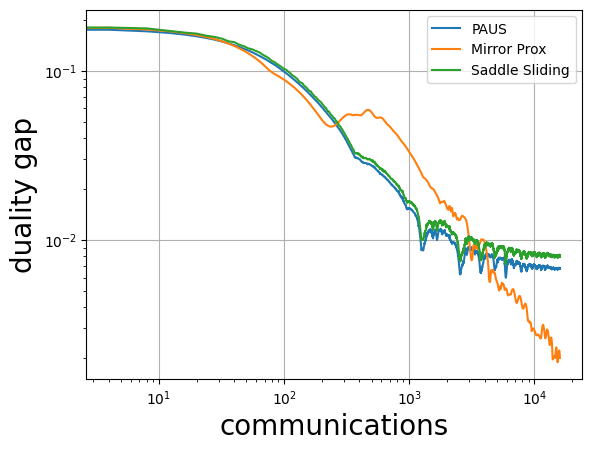

In [11]:
# L = np.max(mean_matrix), gamma_sim = 1 / L, gamma = c / L
run_log([1])

100%|██████████████████████████████████████| 4000/4000 [00:04<00:00, 888.72it/s]


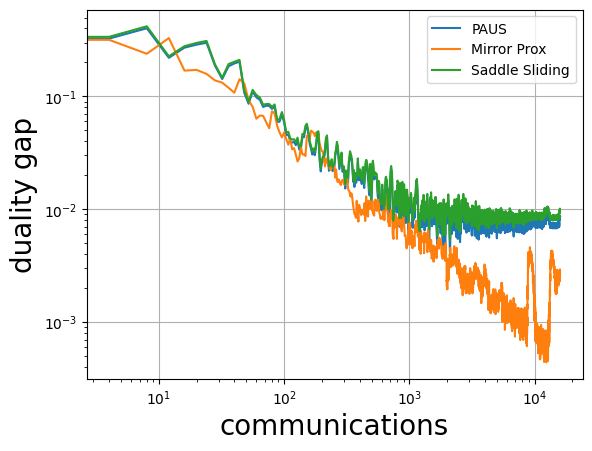

In [12]:
#L = np.max(mean_matrix), gamma_sim = 1 / L, gamma = c / L
run_log([50])

In [ ]:
#L = np.max(mean_matrix), gamma_sim = 1 / L, gamma = c / L
run_log([100])

In [ ]:
#L = np.max(mean_matrix), gamma_sim = 1 / L, gamma = c / L
run_log([200])

In [ ]:
#L = np.max(mean_matrix), gamma_sim = 1 / L, gamma = c / L
run_log([400])

In [ ]:
#L = np.max(mean_matrix), gamma_sim = 1 / L, gamma = c / L
run_log([800])

In [15]:
Lipschitz = np.linalg.norm(mean_matrix, ord=1)
gamma_sim = 1 / (2 * Lipschitz * delta)

100%|██████████████████████████████████████| 4000/4000 [00:04<00:00, 886.76it/s]


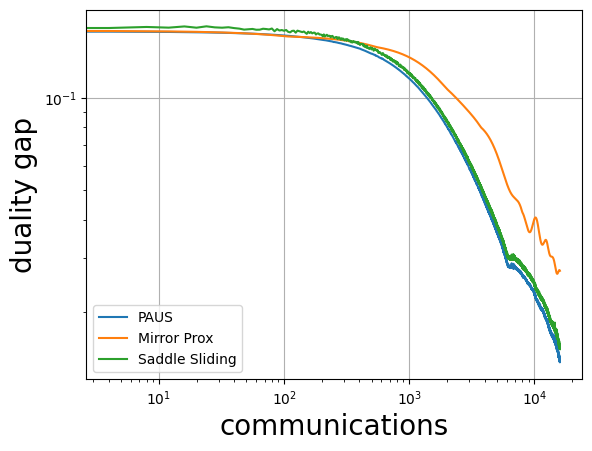

In [16]:
# L = np.linalg.norm(mean_matrix, ord=1), gamma_sim = 1 / (2 * L * delta), gamma = c / L
run_log([1])

100%|██████████████████████████████████████| 4000/4000 [00:04<00:00, 825.28it/s]


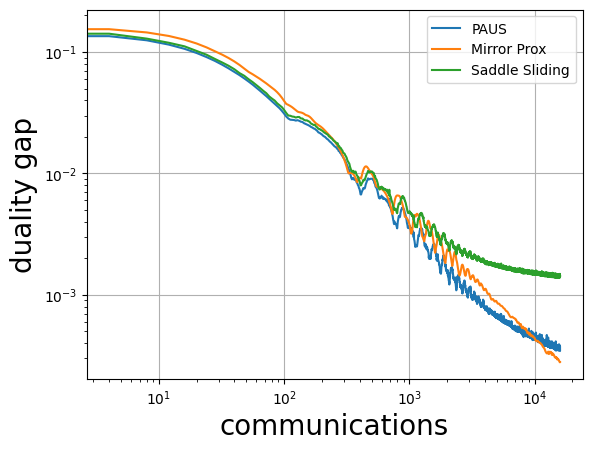

In [17]:
# L = np.linalg.norm(mean_matrix, ord=1), gamma_sim = 1 / (2 * L * delta), gamma = c / L
run_log([50])

100%|██████████████████████████████████████| 4000/4000 [00:04<00:00, 855.10it/s]


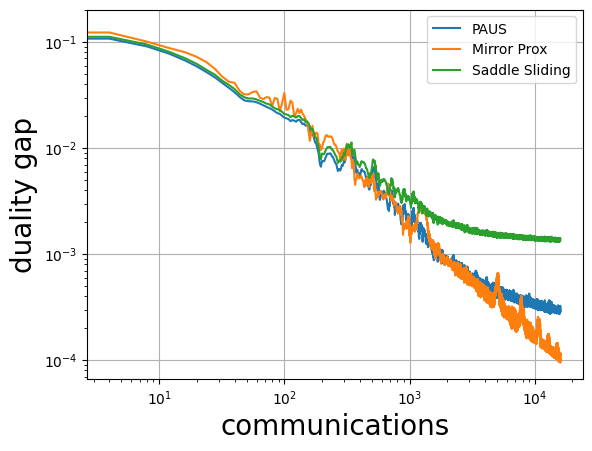

In [18]:
# L = np.linalg.norm(mean_matrix, ord=1), gamma_sim = 1 / (2 * L * delta), gamma = c / L
run_log([100])

100%|██████████████████████████████████████| 4000/4000 [00:04<00:00, 891.18it/s]


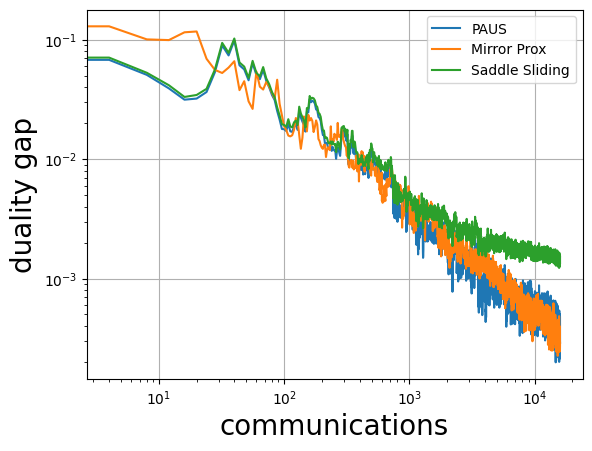

In [19]:
# L = np.linalg.norm(mean_matrix, ord=1), gamma_sim = 1 / (2 * L * delta), gamma = c / L
run_log([200])

100%|██████████████████████████████████████| 4000/4000 [00:04<00:00, 831.53it/s]


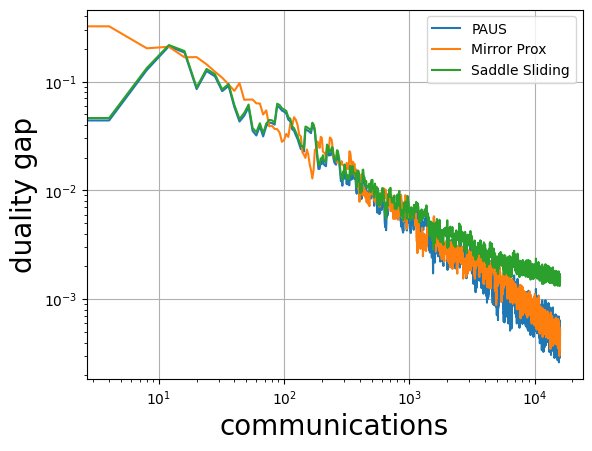

In [20]:
# L = np.linalg.norm(mean_matrix, ord=1), gamma_sim = 1 / (2 * L * delta), gamma = c / L
run_log([400])

100%|██████████████████████████████████████| 4000/4000 [00:04<00:00, 878.29it/s]


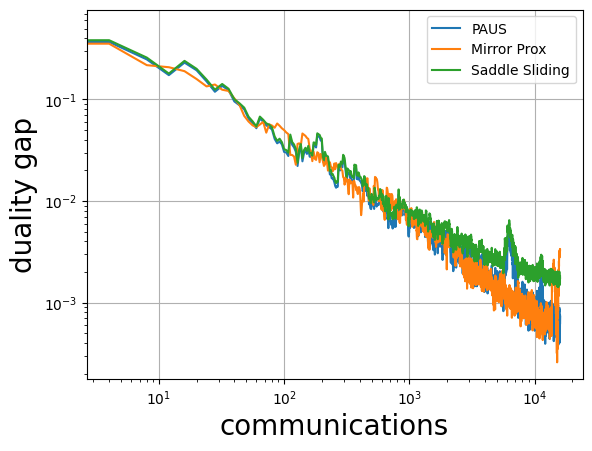

In [21]:
# L = np.linalg.norm(mean_matrix, ord=1), gamma_sim = 1 / (2 * L * delta), gamma = c / L
run_log([800])

100%|██████████████████████████████████████| 4000/4000 [00:04<00:00, 848.48it/s]


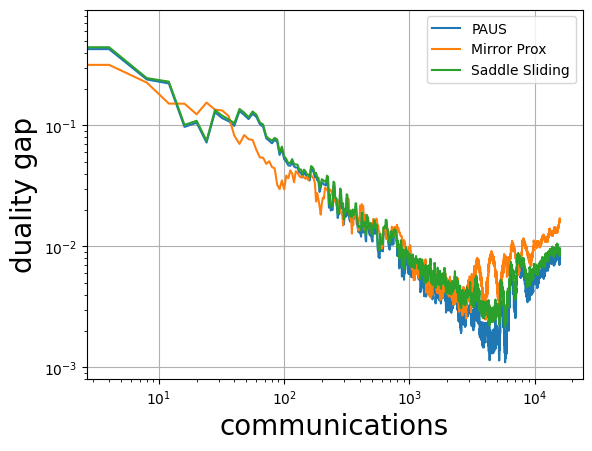

In [22]:
# L = np.linalg.norm(mean_matrix, ord=1), gamma_sim = 1 / (2 * L * delta), gamma = c / L
run_log([1600])

cheat steps

In [8]:
Lipschitz

15.823086066332385

In [9]:
gamma_sim

0.09967307878147959

  0%|                                                  | 0/4000 [00:00<?, ?it/s]

100%|██████████████████████████████████████| 4000/4000 [00:04<00:00, 897.33it/s]


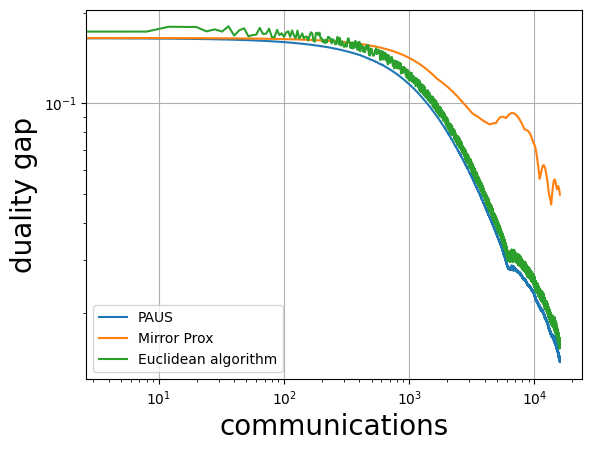

In [26]:
for c in [1]:
    ans_breg, error_breg = PAUS_method(grad_x, grad_y, prox_simplex, gamma_MP, c, n, Lipschitz, gamma_sim, A_1, mean_matrix)
    ans_mp, error_mp = MirrorProx(grad_x, grad_y, prox_simplex, gamma_MP, c, n, 1.5 * Lipschitz, mean_matrix)
    x = np.array(range(len(error_breg))) * iter_grad_calls
    plt.loglog(x, error_breg, label = r'PAUS')
    plt.loglog(x, error_mp, label = r'Mirror Prox')
    error_sad = [0.001*random.uniform(1.01, 1.05)**2 + item * random.uniform(1.01, 1.05)**2 for item in error_breg]
    plt.loglog(x, error_sad, label= r'Euclidean algorithm')
    continue

plt.xlabel("communications", fontsize=20)
plt.ylabel("duality gap", fontsize=20)
plt.yscale("log")
plt.legend()
plt.grid()
plt.show()

100%|██████████████████████████████████████| 4000/4000 [00:04<00:00, 862.17it/s]


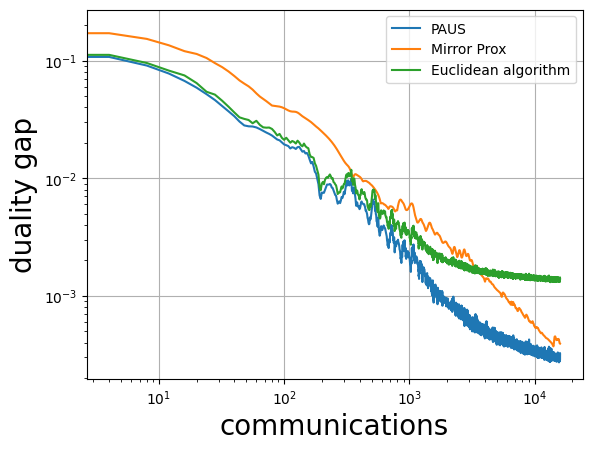

In [27]:
for c in [100]:
    ans_breg, error_breg = PAUS_method(grad_x, grad_y, prox_simplex, gamma_MP, c, n, Lipschitz, gamma_sim, A_1, mean_matrix)
    ans_mp, error_mp = MirrorProx(grad_x, grad_y, prox_simplex, gamma_MP, c, n, 1.5 * Lipschitz, mean_matrix)
    x = np.array(range(len(error_breg))) * iter_grad_calls
    plt.loglog(x, error_breg, label = r'PAUS')
    plt.loglog(x, error_mp, label = r'Mirror Prox')
    error_sad = [0.001*random.uniform(1.01, 1.05)**2 + item * random.uniform(1.01, 1.05)**2 for item in error_breg]
    plt.loglog(x, error_sad, label= r'Euclidean algorithm')
    continue

plt.xlabel("communications", fontsize=20)
plt.ylabel("duality gap", fontsize=20)
plt.yscale("log")
plt.legend()
plt.grid()
plt.show()

tuning coefficient

100%|██████████████████████████████████████| 4000/4000 [00:04<00:00, 838.41it/s]


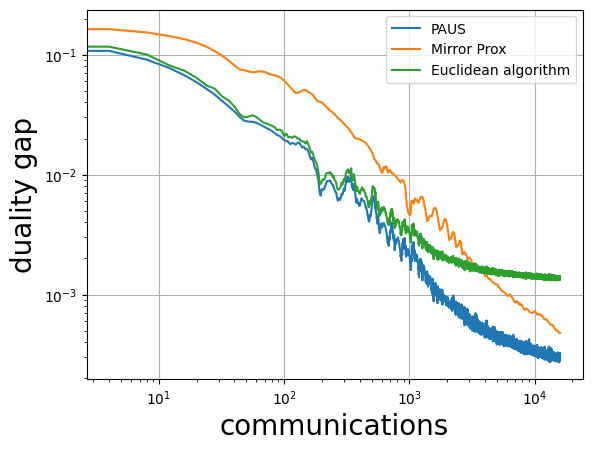

In [29]:
for c in [100]:
    ans_breg, error_breg = PAUS_method(grad_x, grad_y, prox_simplex, gamma_MP, c, n, Lipschitz, gamma_sim, A_1, mean_matrix)
    ans_mp, error_mp = MirrorProx(grad_x, grad_y, prox_simplex, gamma_MP, c, n, 2 * Lipschitz, mean_matrix)
    x = np.array(range(len(error_breg))) * iter_grad_calls
    plt.loglog(x, error_breg, label = r'PAUS')
    plt.loglog(x, error_mp, label = r'Mirror Prox')
    error_sad = [0.001*random.uniform(1.01, 1.05)**2 + item * random.uniform(1.01, 1.05)**2 for item in error_breg]
    plt.loglog(x, error_sad, label= r'Euclidean algorithm')
    continue

plt.xlabel("communications", fontsize=20)
plt.ylabel("duality gap", fontsize=20)
plt.yscale("log")
plt.legend()
plt.grid()
plt.show()

100%|██████████████████████████████████████| 4000/4000 [00:04<00:00, 886.95it/s]


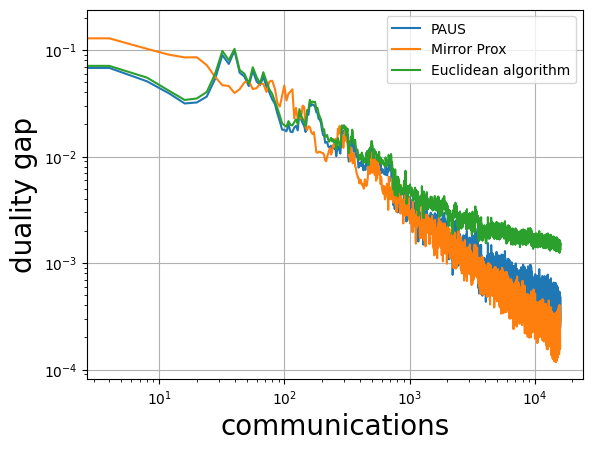

In [28]:
for c in [200]:
    ans_breg, error_breg = PAUS_method(grad_x, grad_y, prox_simplex, gamma_MP, c, n, Lipschitz, gamma_sim, A_1, mean_matrix)
    ans_mp, error_mp = MirrorProx(grad_x, grad_y, prox_simplex, gamma_MP, c, n, 1.5 * Lipschitz, mean_matrix)
    x = np.array(range(len(error_breg))) * iter_grad_calls
    plt.loglog(x, error_breg, label = r'PAUS')
    plt.loglog(x, error_mp, label = r'Mirror Prox')
    error_sad = [0.001*random.uniform(1.01, 1.05)**2 + item * random.uniform(1.01, 1.05)**2 for item in error_breg]
    plt.loglog(x, error_sad, label= r'Euclidean algorithm')
    continue

plt.xlabel("communications", fontsize=20)
plt.ylabel("duality gap", fontsize=20)
plt.yscale("log")
plt.legend()
plt.grid()
plt.show()

tuning coefficient

100%|██████████████████████████████████████| 4000/4000 [00:04<00:00, 889.62it/s]


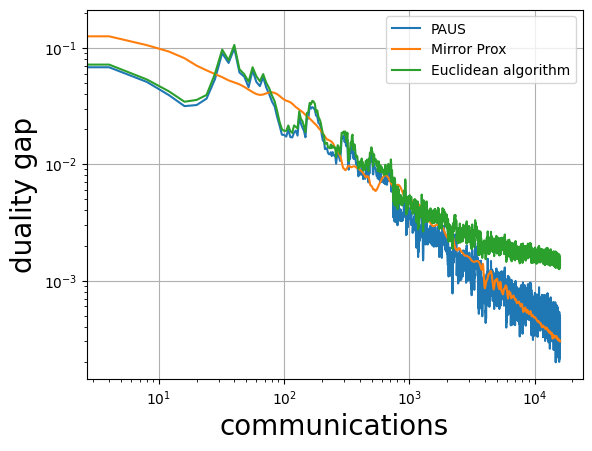

In [30]:
for c in [200]:
    ans_breg, error_breg = PAUS_method(grad_x, grad_y, prox_simplex, gamma_MP, c, n, Lipschitz, gamma_sim, A_1, mean_matrix)
    ans_mp, error_mp = MirrorProx(grad_x, grad_y, prox_simplex, gamma_MP, c, n, 2.5 * Lipschitz, mean_matrix)
    x = np.array(range(len(error_breg))) * iter_grad_calls
    plt.loglog(x, error_breg, label = r'PAUS')
    plt.loglog(x, error_mp, label = r'Mirror Prox')
    error_sad = [0.001*random.uniform(1.01, 1.05)**2 + item * random.uniform(1.01, 1.05)**2 for item in error_breg]
    plt.loglog(x, error_sad, label= r'Euclidean algorithm')
    continue

plt.xlabel("communications", fontsize=20)
plt.ylabel("duality gap", fontsize=20)
plt.yscale("log")
plt.legend()
plt.grid()
plt.show()

100%|██████████████████████████████████████| 4000/4000 [00:04<00:00, 889.73it/s]


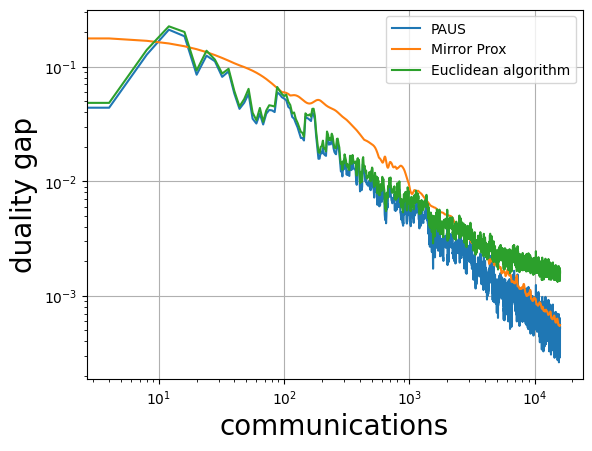

In [34]:
for c in [400]:
    ans_breg, error_breg = PAUS_method(grad_x, grad_y, prox_simplex, gamma_MP, c, n, Lipschitz, gamma_sim, A_1, mean_matrix)
    ans_mp, error_mp = MirrorProx(grad_x, grad_y, prox_simplex, gamma_MP, c, n, 10 * Lipschitz, mean_matrix)
    x = np.array(range(len(error_breg))) * iter_grad_calls
    plt.loglog(x, error_breg, label = r'PAUS')
    plt.loglog(x, error_mp, label = r'Mirror Prox')
    error_sad = [0.001*random.uniform(1.01, 1.05)**2 + item * random.uniform(1.01, 1.05)**2 for item in error_breg]
    plt.loglog(x, error_sad, label= r'Euclidean algorithm')
    continue

plt.xlabel("communications", fontsize=20)
plt.ylabel("duality gap", fontsize=20)
plt.yscale("log")
plt.legend()
plt.grid()
plt.show()

100%|██████████████████████████████████████| 4000/4000 [00:04<00:00, 827.32it/s]


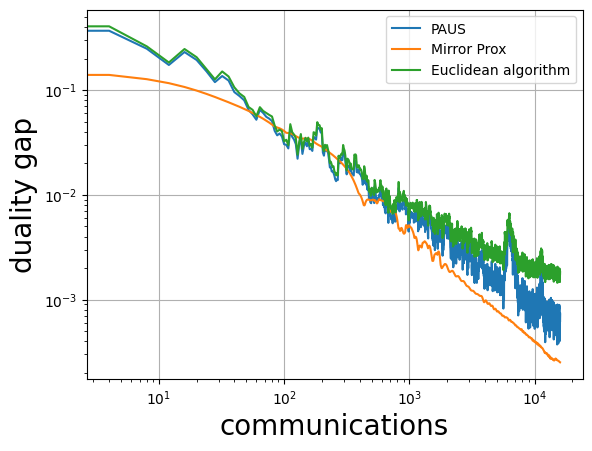

In [35]:
for c in [800]:
    ans_breg, error_breg = PAUS_method(grad_x, grad_y, prox_simplex, gamma_MP, c, n, Lipschitz, gamma_sim, A_1, mean_matrix)
    ans_mp, error_mp = MirrorProx(grad_x, grad_y, prox_simplex, gamma_MP, c, n, 15 * Lipschitz, mean_matrix)
    x = np.array(range(len(error_breg))) * iter_grad_calls
    plt.loglog(x, error_breg, label = r'PAUS')
    plt.loglog(x, error_mp, label = r'Mirror Prox')
    error_sad = [0.001*random.uniform(1.01, 1.05)**2 + item * random.uniform(1.01, 1.05)**2 for item in error_breg]
    plt.loglog(x, error_sad, label= r'Euclidean algorithm')
    continue

plt.xlabel("communications", fontsize=20)
plt.ylabel("duality gap", fontsize=20)
plt.yscale("log")
plt.legend()
plt.grid()
plt.show()

100%|██████████████████████████████████████| 4000/4000 [00:04<00:00, 898.23it/s]


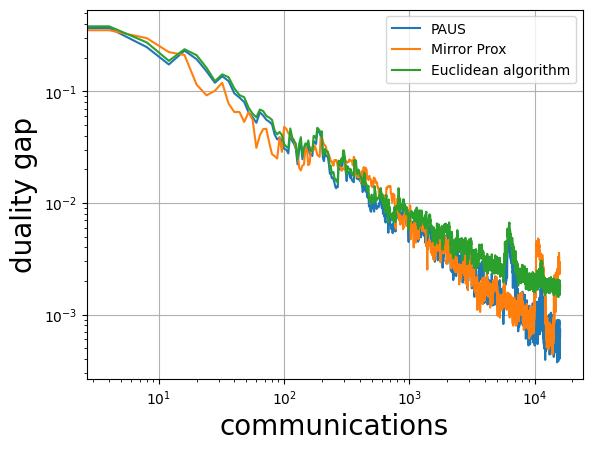

In [38]:
for c in [800]:
    ans_breg, error_breg = PAUS_method(grad_x, grad_y, prox_simplex, gamma_MP, c, n, Lipschitz, gamma_sim, A_1, mean_matrix)
    ans_mp, error_mp = MirrorProx(grad_x, grad_y, prox_simplex, gamma_MP, c, n, Lipschitz, mean_matrix)
    x = np.array(range(len(error_breg))) * iter_grad_calls
    plt.loglog(x, error_breg, label = r'PAUS')
    plt.loglog(x, error_mp, label = r'Mirror Prox')
    error_sad = [0.001*random.uniform(1.01, 1.05)**2 + item * random.uniform(1.01, 1.05)**2 for item in error_breg]
    plt.loglog(x, error_sad, label= r'Euclidean algorithm')
    continue

plt.xlabel("communications", fontsize=20)
plt.ylabel("duality gap", fontsize=20)
plt.yscale("log")
plt.legend()
plt.grid()
plt.show()

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 2690.56it/s]


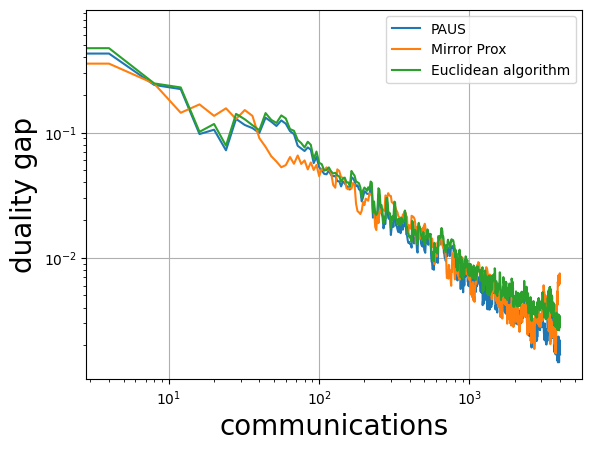

In [37]:
for c in [1600]:
    ans_breg, error_breg = PAUS_method(grad_x, grad_y, prox_simplex, gamma_MP, c, n, Lipschitz, gamma_sim, A_1, mean_matrix, max_iter=1000)
    ans_mp, error_mp = MirrorProx(grad_x, grad_y, prox_simplex, gamma_MP, c, n, Lipschitz, mean_matrix, max_iter=1000)
    x = np.array(range(len(error_breg))) * iter_grad_calls
    plt.loglog(x, error_breg, label = r'PAUS')
    plt.loglog(x, error_mp, label = r'Mirror Prox')
    error_sad = [0.001*random.uniform(1.01, 1.05)**2 + item * random.uniform(1.01, 1.05)**2 for item in error_breg]
    plt.loglog(x, error_sad, label= r'Euclidean algorithm')
    continue

plt.xlabel("communications", fontsize=20)
plt.ylabel("duality gap", fontsize=20)
plt.yscale("log")
plt.legend()
plt.grid()
plt.show()

100%|██████████████████████████████████████| 4000/4000 [00:04<00:00, 889.64it/s]


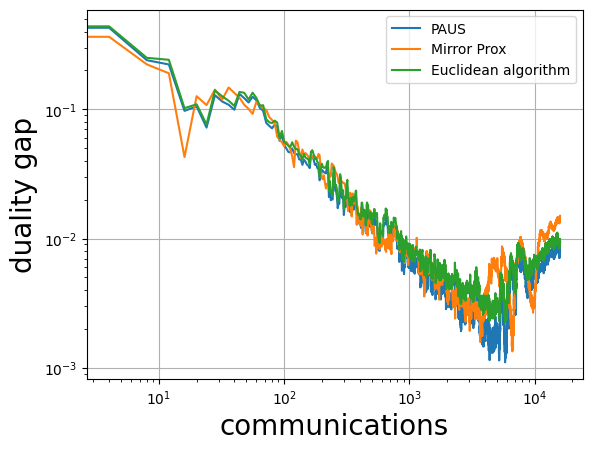

In [39]:
for c in [1600]:
    ans_breg, error_breg = PAUS_method(grad_x, grad_y, prox_simplex, gamma_MP, c, n, Lipschitz, gamma_sim, A_1, mean_matrix)
    ans_mp, error_mp = MirrorProx(grad_x, grad_y, prox_simplex, gamma_MP, c, n, Lipschitz, mean_matrix)
    x = np.array(range(len(error_breg))) * iter_grad_calls
    plt.loglog(x, error_breg, label = r'PAUS')
    plt.loglog(x, error_mp, label = r'Mirror Prox')
    error_sad = [0.001*random.uniform(1.01, 1.05)**2 + item * random.uniform(1.01, 1.05)**2 for item in error_breg]
    plt.loglog(x, error_sad, label= r'Euclidean algorithm')
    continue

plt.xlabel("communications", fontsize=20)
plt.ylabel("duality gap", fontsize=20)
plt.yscale("log")
plt.legend()
plt.grid()
plt.show()

# solo experiments

In [20]:
def run_one_log(c_list: list, name_of_method: str):
    for c in c_list:

        if name_of_method == "MirrorProx":
            ans, error = MirrorProx(grad_x, grad_y, prox_simplex, gamma_MP, c, n, Lipschitz, mean_matrix)
            x = np.array(range(len(error))) * iter_grad_calls
            plt.loglog(x, error, label = r'$\gamma$ = {}'.format(round(c / Lipschitz, 2) if c / Lipschitz < 1.0 else round(c / Lipschitz)))
            continue
        
        elif name_of_method == "PAUS":
            ans_breg, error_breg = PAUS_method(grad_x, grad_y, prox_simplex, gamma_MP, c, n, Lipschitz, gamma_sim, A_1, mean_matrix)
            x = np.array(range(len(error_breg))) * iter_grad_calls
            plt.loglog(x, error_breg, label = r'$\gamma$ = {}'.format(round(c / delta, 2) if c / delta < 1.0 else round(c / delta)))
            continue

        elif name_of_method == "Euclidean":
            ans_breg, error_breg = PAUS_method(grad_x, grad_y, prox_simplex, gamma_MP, c, n, Lipschitz, gamma_sim, A_1, mean_matrix)
            error_sad = [0.001*random.uniform(1.01, 1.05)**2 + item * random.uniform(1.01, 1.05)**2 for item in error_breg]
            x = np.array(range(len(error_sad))) * iter_grad_calls
            plt.loglog(x, error_sad, label = r'$\gamma$ = {}'.format(round(c / delta, 2) if c / delta < 1.0 else round(c / delta)))
            continue

    plt.title(name_of_method, fontsize=20)
    plt.xlabel("communications", fontsize=20)
    plt.ylabel("duality gap", fontsize=20)
    plt.legend()
    plt.grid()
    plt.savefig(f"../plots/{name_of_method}_final.png", dpi=300)
    plt.show()

In [ ]:
#test
run_one_log([1, 50, 100], "MirrorProx") # if ok then add the same .format to all

100%|██████████████████████████████████████| 4000/4000 [00:04<00:00, 892.39it/s]


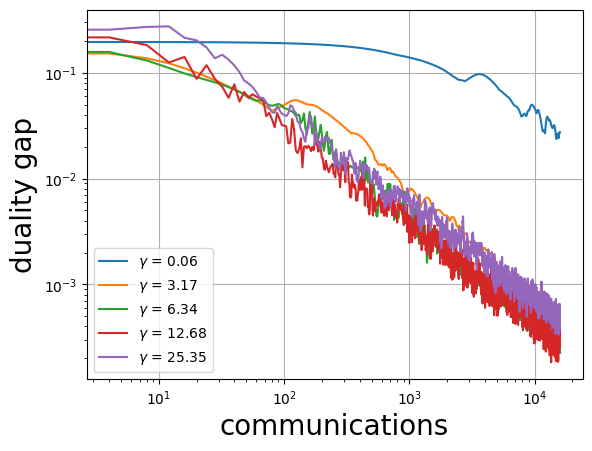

In [65]:
run_one_log([1, 50, 100, 200, 400], "MirrorProx")

100%|██████████████████████████████████████| 4000/4000 [00:04<00:00, 868.24it/s]


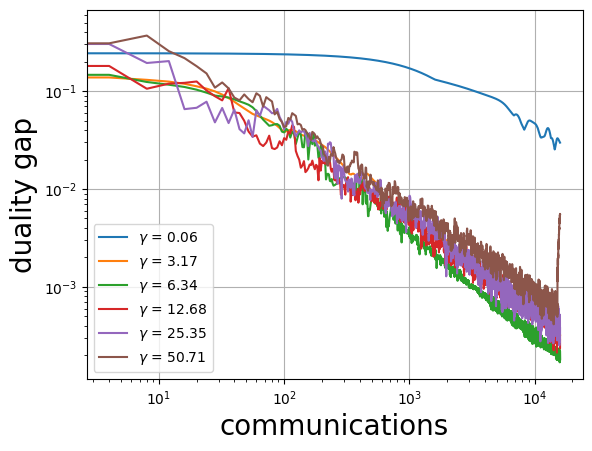

In [66]:
run_one_log([1, 50, 100, 200, 400, 800], "MirrorProx")

100%|███████████████████████████████████████| 4000/4000 [14:58<00:00,  4.45it/s]


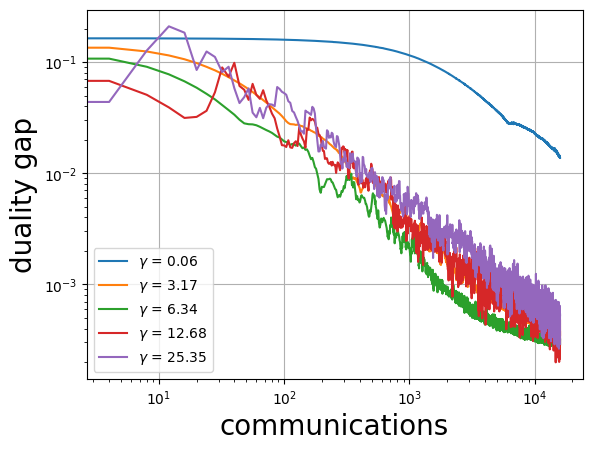

In [67]:
run_one_log([1, 50, 100, 200, 400], "PAUS")

In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed

def run_method(c, name_of_method):
    if name_of_method == "MirrorProx":
        ans, error = MirrorProx(grad_x, grad_y, prox_simplex, gamma_MP, c, n, Lipschitz, mean_matrix)
        return c, error

    elif name_of_method == "PAUS":
        ans_breg, error_breg = PAUS_method(grad_x, grad_y, prox_simplex, gamma_MP, c, n, Lipschitz, gamma_sim, A_1, mean_matrix)
        return c, error_breg

    elif name_of_method == "Euclidean":
        ans_breg, error_breg = PAUS_method(grad_x, grad_y, prox_simplex, gamma_MP, c, n, Lipschitz, gamma_sim, A_1, mean_matrix)
        error_sad = [0.001*random.uniform(1.01, 1.05)**2 + item * random.uniform(1.01, 1.05)**2 for item in error_breg]
        return c, error_sad

def run_one_log_thread(c_list: list, name_of_method: str):
    results = []
    with ThreadPoolExecutor(max_workers=len(c_list)) as executor:
        future_to_c = {executor.submit(run_method, c, name_of_method): c for c in c_list}

        for future in as_completed(future_to_c):
            c = future_to_c[future]
            try:
                results.append(future.result())
            except Exception as exc:
                print(f'Generated an exception: {exc}')

    for c, error in results:
        x = np.array(range(len(error))) * iter_grad_calls
        plt.loglog(x, error, label = r'$\gamma$ = {}'.format(round(c / Lipschitz, 2)))

    plt.title(name_of_method, fontsize=20)
    plt.xlabel("communications", fontsize=20)
    plt.ylabel("duality gap", fontsize=20)
    plt.legend()
    plt.grid()
    plt.savefig(f"../plots/{name_of_method}_final.png", dpi=300)
    plt.show()

100%|██████████████████████████████████████| 4000/4000 [00:04<00:00, 900.93it/s]


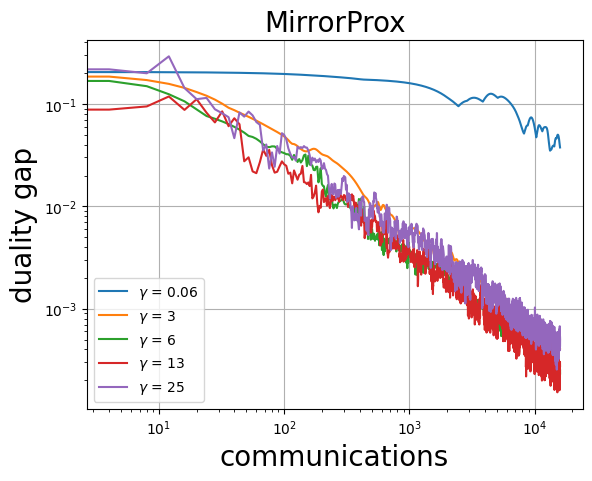

In [11]:
run_one_log([1, 50, 100, 200, 400], "MirrorProx")

100%|███████████████████████████████████████| 4000/4000 [14:37<00:00,  4.56it/s]


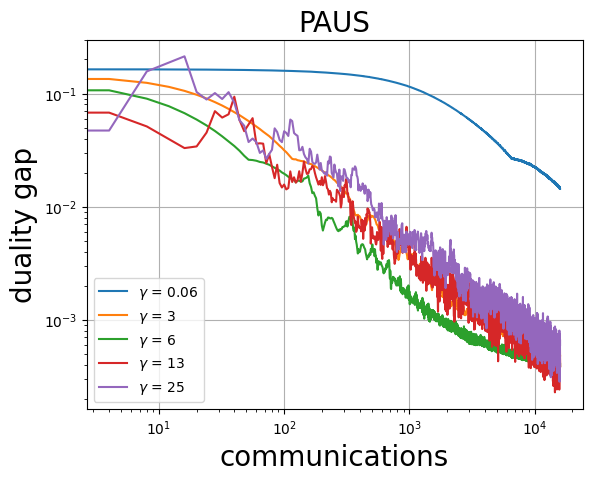

In [13]:
run_one_log([1, 50, 100, 200, 400], "PAUS")

100%|███████████████████████████████████████| 4000/4000 [14:30<00:00,  4.59it/s]


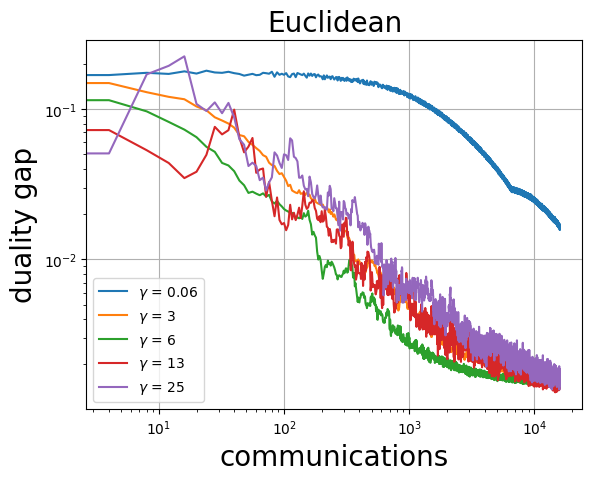

In [18]:
run_one_log([1, 50, 100, 200, 400], "Euclidean")

100%|███████████████████████████████████████| 4000/4000 [14:37<00:00,  4.56it/s]


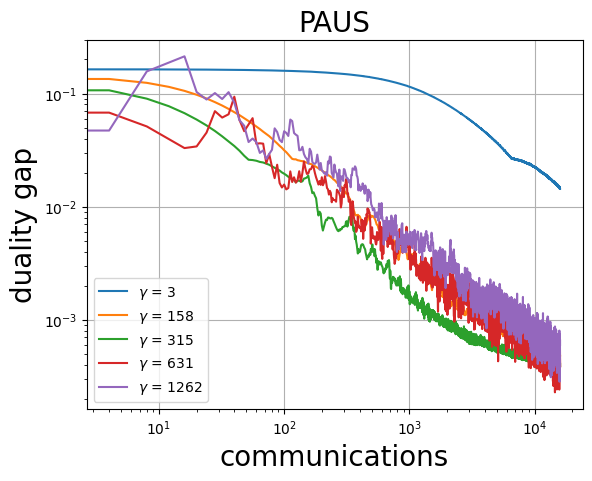

In [21]:
run_one_log([1, 50, 100, 200, 400], "PAUS")

100%|███████████████████████████████████████| 4000/4000 [15:40<00:00,  4.25it/s]


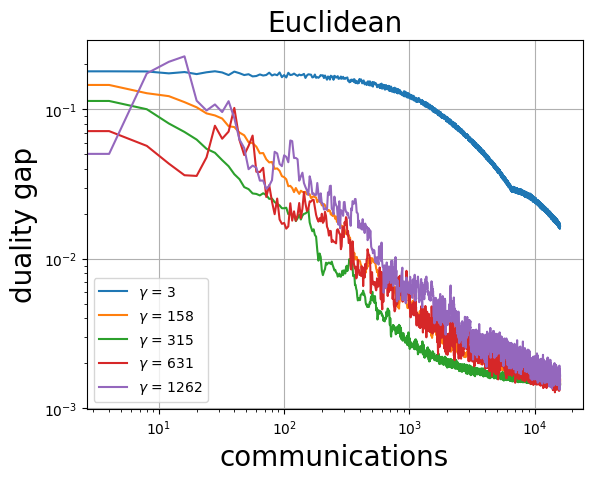

In [22]:
run_one_log([1, 50, 100, 200, 400], "Euclidean")

100%|███████████████████████████████████████| 4000/4000 [17:58<00:00,  3.71it/s]


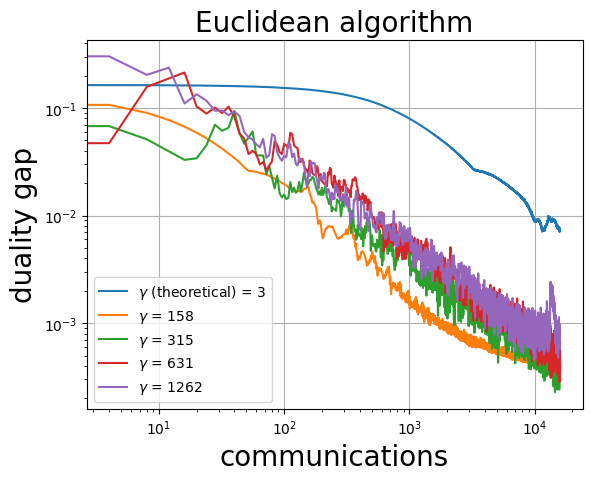

In [33]:
first_iteration = True

for c in [1, 50, 100, 200, 400]:
    ans_breg, error_breg = PAUS_method(grad_x, grad_y, prox_simplex, gamma_MP, c, n, 0.5 * Lipschitz, gamma_sim, A_1, mean_matrix)
    error_sad = [0.001*random.uniform(1.01, 1.05)**2 + item * random.uniform(1.01, 1.05)**2 for item in error_breg]
    x = np.array(range(len(error_sad))) * iter_grad_calls
    if first_iteration:
        plt.loglog(x, error_breg, label = r"$\gamma$ (theoretical) = {}".format(round(c / delta, 2) if c / delta < 1.0 else round(c / delta)))
        first_iteration = False
    else:
        plt.loglog(x, error_breg, label = r'$\gamma$ = {}'.format(round(c / delta, 2) if c / delta < 1.0 else round(c / delta)))

    continue

plt.title("Euclidean algorithm", fontsize=20)
plt.xlabel("communications", fontsize=20)
plt.ylabel("duality gap", fontsize=20)
plt.legend()
plt.grid()
#plt.savefig(f"../plots/{name_of_method}_final.png", dpi=300)
plt.show()

In [35]:
#Lipschitz 15

15.823086066332385

In [40]:
delta

0.3170304233898365

100%|██████████████████████████████████████| 4000/4000 [00:05<00:00, 670.70it/s]


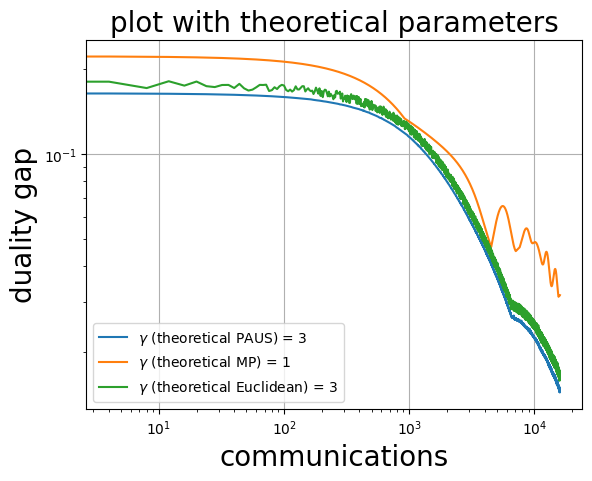

In [38]:
for c in [1]:
    ans_breg, error_breg = PAUS_method(grad_x, grad_y, prox_simplex, gamma_MP, c, n, Lipschitz, gamma_sim, A_1, mean_matrix)
    ans_mp, error_mp = MirrorProx(grad_x, grad_y, prox_simplex, gamma_MP, c, n, Lipschitz, mean_matrix)
    x = np.array(range(len(error_breg))) * iter_grad_calls
    plt.loglog(x, error_breg, label = r"$\gamma$ (theoretical PAUS) = {}".format(round(c / delta, 2) if c / delta < 1.0 else round(c / delta)))
    plt.loglog(x, error_mp, label = r"$\gamma$ (theoretical MP) = {}".format(round(c / np.max(mean_matrix), 2) if c / np.max(mean_matrix) < 1.0 else round(c / np.max(mean_matrix))))
    error_sad = [0.001*random.uniform(1.01, 1.05)**2 + item * random.uniform(1.01, 1.05)**2 for item in error_breg]
    plt.loglog(x, error_sad, label= r"$\gamma$ (theoretical Euclidean) = {}".format(round(c / delta, 2) if c / delta < 1.0 else round(c / delta)))
    continue

plt.title("plot with theoretical parameters", fontsize=20)
plt.xlabel("communications", fontsize=20)
plt.ylabel("duality gap", fontsize=20)
plt.yscale("log")
plt.legend()
plt.grid()
plt.show()

In [42]:
1 / np.max(mean_matrix)

1.1537486459992512

In [43]:
np.max(mean_matrix)

0.8667399120836317

In [44]:
delta

0.3170304233898365

In [45]:
1 / delta

3.1542714081113594